This lab is based on the paper called "Domain Adaptation by Using Causal Inference to Predict Invariant Conditional Distributions" by Magliacane et al, 2018. https://arxiv.org/pdf/1707.06422.pdf

Underlying causal mechanism should be described by variables that are invariant to the changes in the distribution between source and target domain. This is the idea of this asignment. 

In [1]:
import time
import numpy as np
import pandas as pd
import random
import copy
from sklearn import metrics
from random import randrange
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import math
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor

In [2]:
import pandas as pd
import numpy as np

# Function to generate data for a single domain
def generate_domain_data(num_samples, domain, num_non_informative_features=2):
    # Generate categorical features
    
    # Generate informative feature 1 (consistent across domains)
    y = np.random.normal(0, 1, num_samples)
    invariant_feature_values = y + np.random.normal(0, 1, num_samples)
        
    # Generate informative feature 2 (varying across domains)
    if domain == 1:
        noninvariant_feature_values = y + np.random.normal(0, 0.05, num_samples)
    elif domain == 2:
        noninvariant_feature_values = np.random.normal(0, 0.05, num_samples)
    else:
        noninvariant_feature_values = -y + np.random.normal(0, 0.05, num_samples)
    
    # Generate non-informative features
    non_informative_features = {}
    for i in range(num_non_informative_features):
        non_informative_feature = np.random.normal(0, 1, num_samples)
        non_informative_features[f'uninformative feature_{i+1}'] = non_informative_feature
    
    # Create DataFrame
    df = pd.DataFrame({
        'domain': domain,
        'invariant feature': invariant_feature_values,
        'noninvariant feature': noninvariant_feature_values,
        **non_informative_features,
        'y': y
    })
    
    return df

# Define parameters
num_samples = 1000
num_non_informative_features = 2


# Generate data for three domains
domain1_data = generate_domain_data(num_samples, domain=1, num_non_informative_features=num_non_informative_features)
domain2_data = generate_domain_data(num_samples, domain=2, num_non_informative_features=num_non_informative_features)
domain3_data = generate_domain_data(num_samples, domain=3, num_non_informative_features=num_non_informative_features)

# Combine data from different domains
combined_data = pd.concat([domain1_data, domain2_data, domain3_data], ignore_index=True)
combined_data.head()

,domain,invariant feature,noninvariant feature,uninformative feature_1,uninformative feature_2,y
0,1,0.230218,1.579208,2.330099,-0.488854,1.559292
1,1,-0.404207,-0.123833,1.723834,-0.263995,-0.287975
2,1,-1.749401,-0.464917,-0.717202,0.995847,-0.482884
3,1,-0.918136,1.405661,-0.855450,-2.493419,1.436917
4,1,-1.874943,-0.071436,-0.493707,-1.918054,-0.048717


In [3]:
combined_data.shape

(3000, 6)

In [4]:
np.unique(combined_data.domain)

array([1, 2, 3])

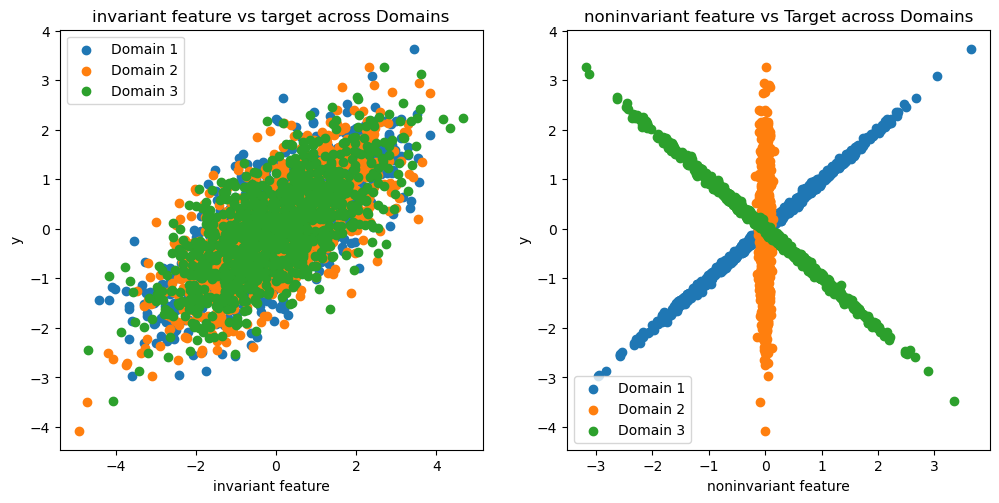

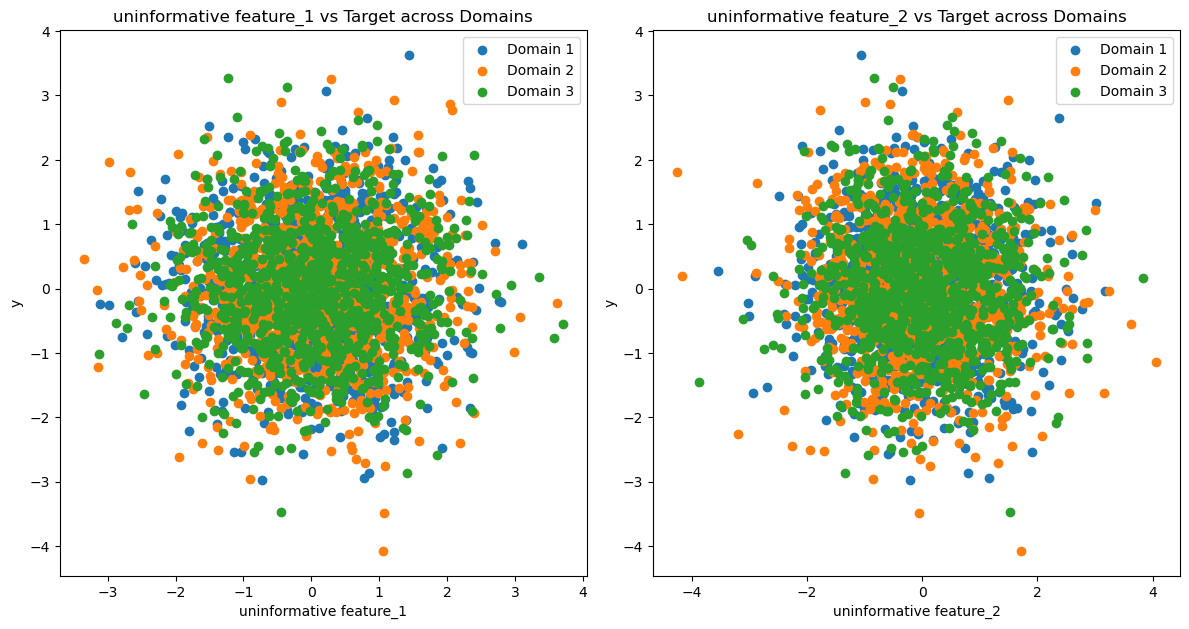

In [68]:
import matplotlib.pyplot as plt

# Create scatter plots for informative_feature_1 and target variable (Target) across different domains
plt.figure(figsize=(12, 12))

# First figure (top row)
plt.subplot(2, 2, 1)
plt.scatter(domain1_data['invariant feature'], domain1_data['y'], label='Domain 1')
plt.scatter(domain2_data['invariant feature'], domain2_data['y'], label='Domain 2')
plt.scatter(domain3_data['invariant feature'], domain3_data['y'], label='Domain 3')
plt.xlabel('invariant feature')
plt.ylabel('y')
plt.title('invariant feature vs target across Domains')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(domain1_data['noninvariant feature'], domain1_data['y'], label='Domain 1')
plt.scatter(domain2_data['noninvariant feature'], domain2_data['y'], label='Domain 2')
plt.scatter(domain3_data['noninvariant feature'], domain3_data['y'], label='Domain 3')
plt.xlabel('noninvariant feature')
plt.ylabel('y')
plt.title('noninvariant feature vs Target across Domains')
plt.legend()

# Second figure (bottom row)
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.scatter(domain1_data['uninformative feature_1'], domain1_data['y'], label='Domain 1')
plt.scatter(domain2_data['uninformative feature_1'], domain2_data['y'], label='Domain 2')
plt.scatter(domain3_data['uninformative feature_1'], domain3_data['y'], label='Domain 3')
plt.xlabel('uninformative feature_1')
plt.ylabel('y')
plt.title('uninformative feature_1 vs Target across Domains')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(domain1_data['uninformative feature_2'], domain1_data['y'], label='Domain 1')
plt.scatter(domain2_data['uninformative feature_2'], domain2_data['y'], label='Domain 2')
plt.scatter(domain3_data['uninformative feature_2'], domain3_data['y'], label='Domain 3')
plt.xlabel('uninformative feature_2')
plt.ylabel('y')
plt.title('uninformative feature_2 vs Target across Domains')
plt.legend()

plt.tight_layout()
plt.show()


# Training on all the features

In [6]:
# Create train data (domains A and B)
train_data = combined_data[combined_data['domain'].isin([1, 2])]

# Create test data (domain C)
test_data = combined_data[combined_data['domain'] == 3]

# Select features and target for training
X_train = train_data.drop(['domain', 'y'], axis=1).values
y_train = train_data['y'].values

# Select features and target for testing
X_test = test_data.drop(['domain', 'y'], axis=1).values
y_test = test_data['y'].values

# Train Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=11, random_state=100)
rf_regressor.fit(X_train, y_train)

# Predict on test data
y_pred = rf_regressor.predict(X_test)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("MAE for the target domain 3, after training with source domains 1 and 2: {:.4f}".format(mae))





MAE for the target domain 3, after training with source domains 1 and 2: 1.4775


# Invariant Feature Selection

<div class="alert alert-block alert-warning">
    
What will be Mean square error when you select the invariant feature in compare to non-invariant feature? 
Do you think selecting more than one feature improves the results?


</div>

In [56]:
selected_indexes = [0] #TODO: select the right feature, e.g. 0, 1, 2, 3

print('Selected features:', selected_indexes)

Selected features: [0]


In [57]:
from sklearn.metrics import mean_squared_error
rf_regressor.fit(X_train[:, selected_indexes], y_train)

# Predict on test data
y_pred = rf_regressor.predict(X_test[:, selected_indexes])

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("MAE for the target domain 3, after training with source domains 1 and 2 with invariant features: {:.4f}".format(mae))
# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("MSE for the target domain 3, after training with source domains 1 and 2 with invariant features: {:.4f}".format(mse))


MAE for the target domain 3, after training with source domains 1 and 2 with invariant features: 0.6789
MSE for the target domain 3, after training with source domains 1 and 2 with invariant features: 0.7306


In [58]:
selected_indexes = [0, 2, 3] #TODO: select the right feature, e.g. 0, 1, 2, 3

print('Selected features:', selected_indexes)
rf_regressor.fit(X_train[:, selected_indexes], y_train)

# Predict on test data
y_pred = rf_regressor.predict(X_test[:, selected_indexes])

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("MAE for the target domain 3, after training with source domains 1 and 2 with invariant features: {:.4f}".format(mae))
# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("MSE for the target domain 3, after training with source domains 1 and 2 with invariant features: {:.4f}".format(mse))


Selected features: [0, 2, 3]
MAE for the target domain 3, after training with source domains 1 and 2 with invariant features: 0.6213
MSE for the target domain 3, after training with source domains 1 and 2 with invariant features: 0.6133


In [ ]:
#The result was much improved with variable 0 (invariant). When selecting 2 or 3 features (non-informative) 
#the result was slightly improved (about 0.05 in absolute error). I am not sure why, since the uninformatives are just noise.
#Maybe they decreased the complexity of the model which improved the performance.
